In [1]:
import os
import numpy as np
import pandas as pd
from monai.utils import  first, set_determinism
import monai.transforms as transforms
from monai.transforms import Compose
from monai.visualize import matshow3d
from torch import torch
from monai.metrics import DiceMetric
import glob as glob 

# Setup data directory
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = os.getcwd() if directory is None else directory
print(root_dir)

# Set deterministic training for reproducibility
set_determinism(seed=0)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


/home/hua/Muscle_seg


# Dice for Algorithm selection

In [13]:
def create_dict():
    # Set the base path for the predictions
    base_path = os.path.join(root_dir, './Data/Stage_1/swinunetr_0/Helsinki/')  
    
    # Set the path for the label folder
    label_path = os.path.join(root_dir, './Data/Stage_1/Helsinki_label')
    
    # Find all predictions files
    predict_files = glob.glob(os.path.join(base_path, 'THIGH_*.nii.gz'))
    
    # Initialize an empty list for the dictionary
    ddict = []
    
    # Loop through each label file
    for prediction in predict_files:
        # Extract the prediction file name
        stripped_base_name = os.path.basename(prediction).split('_')[0:2]
        predict_name = "_".join(stripped_base_name) + '.nii.gz'
        
        # Extract the image file names for each type
        label_files = glob.glob(os.path.join(label_path, predict_name))

        # Create a dictionary for each set of files
        for i in range(len(label_files)):
            ddict.append({'label': label_files[i], 'predict': prediction})

    return ddict

Dice_dict = create_dict()
Dice_dict

[{'label': '/home/hua/Muscle_seg/./Data/Stage_1/Helsinki_label/THIGH_117.nii.gz',
  'predict': '/home/hua/Muscle_seg/./Data/Stage_1/swinunetr_0/Helsinki/THIGH_117_0000_seg.nii.gz'},
 {'label': '/home/hua/Muscle_seg/./Data/Stage_1/Helsinki_label/THIGH_117.nii.gz',
  'predict': '/home/hua/Muscle_seg/./Data/Stage_1/swinunetr_0/Helsinki/THIGH_117_0001_seg.nii.gz'},
 {'label': '/home/hua/Muscle_seg/./Data/Stage_1/Helsinki_label/THIGH_121.nii.gz',
  'predict': '/home/hua/Muscle_seg/./Data/Stage_1/swinunetr_0/Helsinki/THIGH_121_0001_seg.nii.gz'},
 {'label': '/home/hua/Muscle_seg/./Data/Stage_1/Helsinki_label/THIGH_107.nii.gz',
  'predict': '/home/hua/Muscle_seg/./Data/Stage_1/swinunetr_0/Helsinki/THIGH_107_0000_seg.nii.gz'},
 {'label': '/home/hua/Muscle_seg/./Data/Stage_1/Helsinki_label/THIGH_123.nii.gz',
  'predict': '/home/hua/Muscle_seg/./Data/Stage_1/swinunetr_0/Helsinki/THIGH_123_0000_seg.nii.gz'},
 {'label': '/home/hua/Muscle_seg/./Data/Stage_1/Helsinki_label/THIGH_108.nii.gz',
  'predi

In [14]:
# label one-hot transfromation
class ConvertToMultiChannelfromlabelsd(transforms.MapTransform):
    """"""
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            #print(key)
            # one-hot iteration
            result = []
            for i in range(1, 12):
                result.append(d[key] == i)
                #print(result[i-1].shape)
                #print(len(result))
            d[key] = torch.stack(result, axis=0)#.astype(np.float32)
        return d


Transform = Compose([
    transforms.LoadImaged(keys=["predict", "label"]), 
    ConvertToMultiChannelfromlabelsd(keys=["predict", "label"]),
    #transforms.EnsureChannelFirstd(keys=["predict", "label"]), 
    transforms.EnsureTyped(keys=["predict", "label"])
    ])

Test = Transform(Dice_dict[0])
print(Test['predict'].shape)
print(Test['label'].shape)

torch.Size([11, 320, 320, 21])
torch.Size([11, 320, 320, 21])


monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [16]:
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
dice_metric(y_pred=Test['predict'], y=Test['label'])
dice_metric.aggregate(reduction="mean")

tensor([0.4294])

In [17]:
Dice_log = []

for pair in Dice_dict:
    MRI_pair = Transform(pair)
    MRI_name = os.path.basename(MRI_pair['predict_meta_dict']['filename_or_obj'])
    print(MRI_name)
    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
    dice_metric(y_pred=MRI_pair['predict'], y=MRI_pair['label'])
    dice_mean = dice_metric.aggregate(reduction="mean").item()
    Dice_log.append(dice_mean)


mean = sum(Dice_log) / len(Dice_log)
mean

THIGH_117_0000_seg.nii.gz
THIGH_117_0001_seg.nii.gz
THIGH_121_0001_seg.nii.gz
THIGH_107_0000_seg.nii.gz
THIGH_123_0000_seg.nii.gz
THIGH_108_0000_seg.nii.gz
THIGH_123_0001_seg.nii.gz
THIGH_119_0000_seg.nii.gz
THIGH_106_0001_seg.nii.gz
THIGH_121_0000_seg.nii.gz
THIGH_107_0001_seg.nii.gz
THIGH_108_0001_seg.nii.gz
THIGH_106_0000_seg.nii.gz


0.344791238124554

# Dice for the final model (testing MRIs)

In [37]:
def create_dict():
    # Set the base path for the predictions
    base_path = os.path.join(root_dir, './Data/Stage_2/T2/')  
    
    # Set the path for the label folder
    label_path = os.path.join(root_dir, './Data/Stage_2/Label')
    
    # Find all predictions files
    predict_files = glob.glob(os.path.join(base_path, '*.nii.gz'))
    
    # Initialize an empty list for the dictionary
    ddict = []
    
    # Loop through each label file
    for prediction in predict_files:
        # Extract the prediction file name
        stripped_base_name = os.path.basename(prediction).split('_')[0:2]
        predict_name = "_".join(stripped_base_name) + '.nii.gz'
        
        # Extract the image file names for each type
        label_files = glob.glob(os.path.join(label_path, predict_name))

        # Create a dictionary for each set of files
        for i in range(len(label_files)):
            ddict.append({'label': label_files[i], 'predict': prediction})

    return ddict

Dice_dict = create_dict()
Dice_dict

[{'label': '/home/hua/Muscle_seg/./Data/Stage_2/Label/THIGH_034.nii.gz',
  'predict': '/home/hua/Muscle_seg/./Data/Stage_2/T2/THIGH_034_0003.nii.gz'},
 {'label': '/home/hua/Muscle_seg/./Data/Stage_2/Label/THIGH_061.nii.gz',
  'predict': '/home/hua/Muscle_seg/./Data/Stage_2/T2/THIGH_061_0003.nii.gz'},
 {'label': '/home/hua/Muscle_seg/./Data/Stage_2/Label/THIGH_046.nii.gz',
  'predict': '/home/hua/Muscle_seg/./Data/Stage_2/T2/THIGH_046_0003.nii.gz'},
 {'label': '/home/hua/Muscle_seg/./Data/Stage_2/Label/THIGH_064.nii.gz',
  'predict': '/home/hua/Muscle_seg/./Data/Stage_2/T2/THIGH_064_0003.nii.gz'},
 {'label': '/home/hua/Muscle_seg/./Data/Stage_2/Label/THIGH_029.nii.gz',
  'predict': '/home/hua/Muscle_seg/./Data/Stage_2/T2/THIGH_029_0003.nii.gz'},
 {'label': '/home/hua/Muscle_seg/./Data/Stage_2/Label/THIGH_038.nii.gz',
  'predict': '/home/hua/Muscle_seg/./Data/Stage_2/T2/THIGH_038_0003.nii.gz'},
 {'label': '/home/hua/Muscle_seg/./Data/Stage_2/Label/THIGH_035.nii.gz',
  'predict': '/home/h

In [19]:
# label one-hot transfromation
class ConvertToMultiChannelfromlabelsd(transforms.MapTransform):
    """"""
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            #print(key)
            # one-hot iteration
            result = []
            for i in range(1, 12):
                result.append(d[key] == i)
                #print(result[i-1].shape)
                #print(len(result))
            d[key] = torch.stack(result, axis=0)#.astype(np.float32)
        return d


Transform = Compose([
    transforms.LoadImaged(keys=["predict", "label"]), 
    ConvertToMultiChannelfromlabelsd(keys=["predict", "label"]),
    #transforms.EnsureChannelFirstd(keys=["predict", "label"]), 
    transforms.EnsureTyped(keys=["predict", "label"])
    ])

Test = Transform(Dice_dict[0])
print(Test['predict'].shape)
print(Test['label'].shape)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


torch.Size([11, 560, 560, 65])
torch.Size([11, 560, 560, 65])


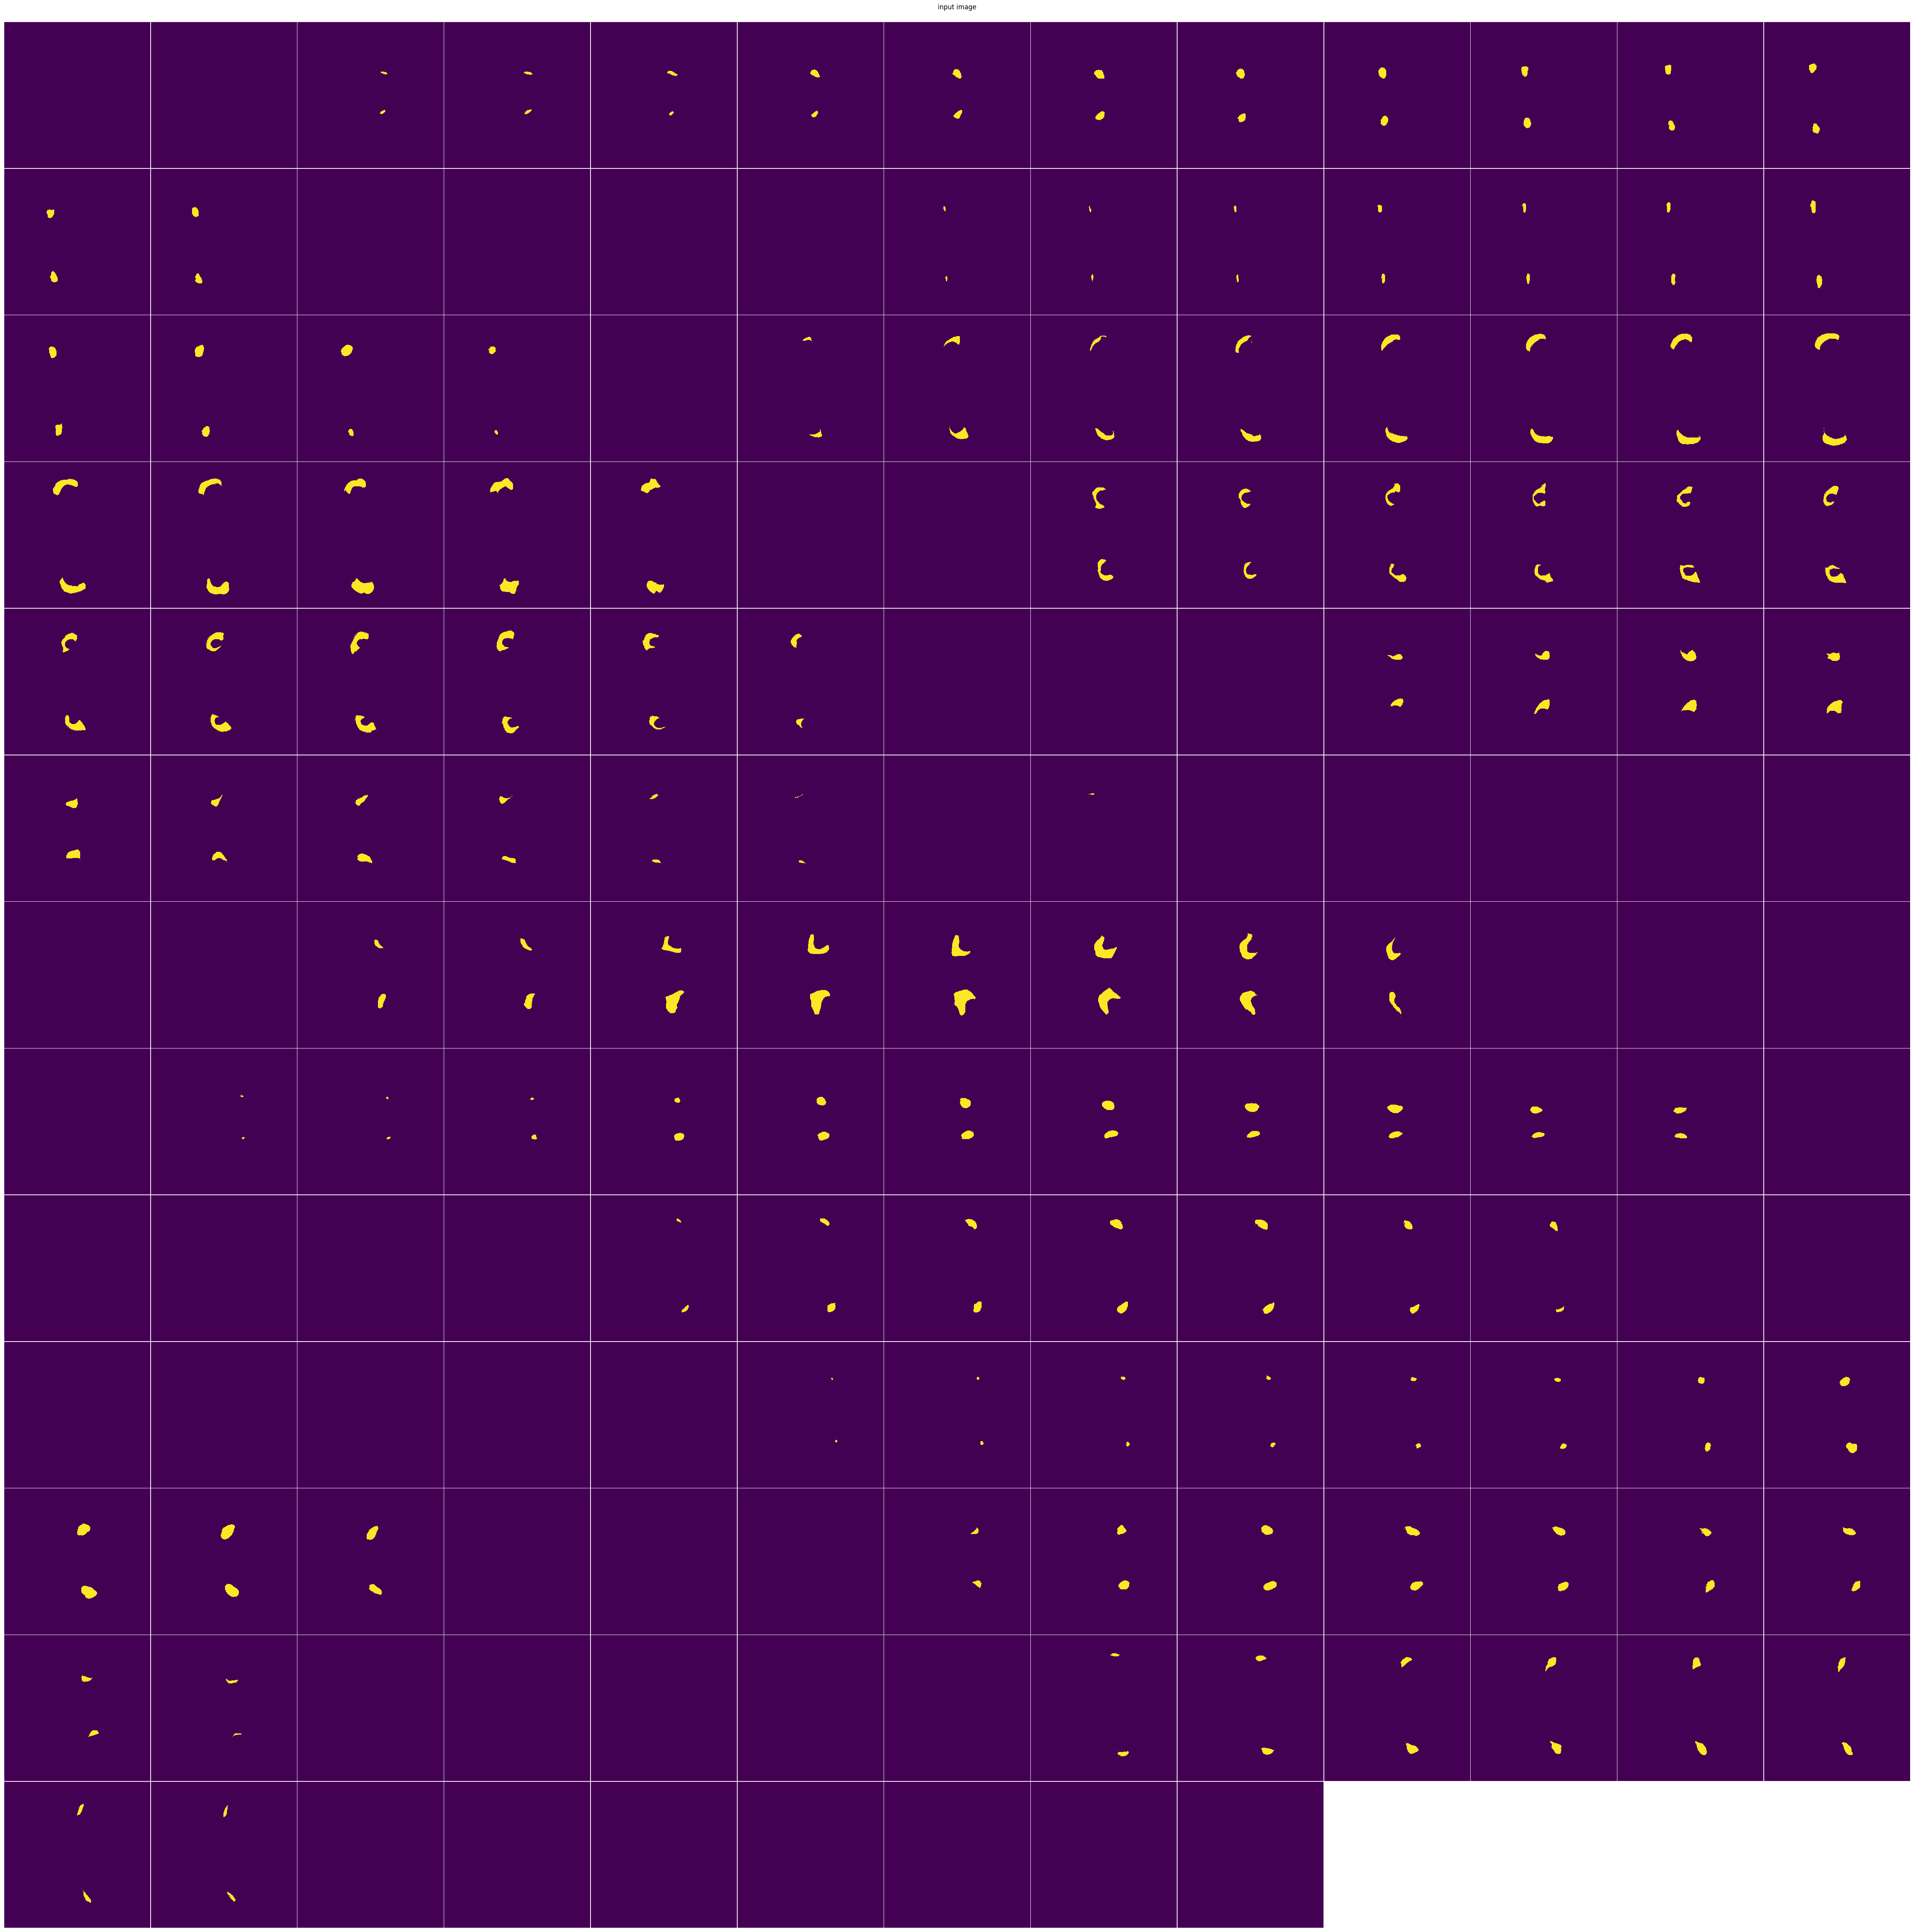

(<Figure size 5000x5000 with 1 Axes>,
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        ...,
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32))

In [25]:
matshow3d(
    volume=Test['label'], #val_label_convert, val_output_convert
    fig=None,
    title="input image",
    figsize=(50, 50),
    every_n=1,
    frame_dim=-1,
    show=True,
)

In [9]:
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

MRI_pair = Transform(Dice_dict[1])
#MRI_name = os.path.basename(MRI_pair['predict_meta_dict']['filename_or_obj'])
#print(MRI_name)
dice_metric(y_pred=MRI_pair['predict'], y=MRI_pair['label'])
dice_metrics = dice_metric.aggregate(reduction="mean_channel")
dice_metrics


tensor([0.8146, 0.8004, 0.7683, 0.7624, 0.7341, 0.7716, 0.8225, 0.8486, 0.8683,
        0.7729, 0.7366])

In [38]:
MRI_sample = []; SA = []; RF = []; VL = []; VI = []; VM = []; AM = []; GR = []; BL = []; ST = []; SM = []; BB = []

for pair in Dice_dict:
    MRI_pair = Transform(pair)
    MRI_name = os.path.basename(MRI_pair['predict_meta_dict']['filename_or_obj'])
    print(MRI_name)
    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
    dice_metric(y_pred=MRI_pair['predict'], y=MRI_pair['label'])
    dice_metrics = dice_metric.aggregate(reduction="mean_channel")
    MRI_sample.append(MRI_name)
    SA.append(dice_metrics[0].item())
    RF.append(dice_metrics[1].item())
    VL.append(dice_metrics[2].item())
    VI.append(dice_metrics[3].item())
    VM.append(dice_metrics[4].item())
    AM.append(dice_metrics[5].item())
    GR.append(dice_metrics[6].item())
    BL.append(dice_metrics[7].item())
    ST.append(dice_metrics[8].item())
    SM.append(dice_metrics[9].item())
    BB.append(dice_metrics[10].item())

Dice_table = {'MRI_sample': MRI_sample, 'SA': SA, 'RF': RF, 'VL': VL, 'VI': VI, 'VM': VM, 'AM': AM, 'GR': GR, 'BL': BL, 'ST': ST, 'SM': SM, 'BB': BB}
pd.DataFrame(Dice_table).to_excel('T2 final model.xlsx', index=False)
pd.DataFrame(Dice_table)


THIGH_034_0003.nii.gz
THIGH_061_0003.nii.gz
THIGH_046_0003.nii.gz
THIGH_064_0003.nii.gz
THIGH_029_0003.nii.gz
THIGH_038_0003.nii.gz
THIGH_035_0003.nii.gz
THIGH_054_0003.nii.gz


,MRI_sample,SA,RF,VL,VI,VM,AM,GR,BL,ST,SM,BB
0,THIGH_034_0003.nii.gz,0.796251,0.839367,0.798273,0.640001,0.757825,0.734285,0.830344,0.665251,0.540132,0.675827,0.650379
1,THIGH_061_0003.nii.gz,0.885647,0.890167,0.885413,0.836773,0.794253,0.819574,0.875217,0.871137,0.811692,0.856184,0.697916
2,THIGH_046_0003.nii.gz,0.843923,0.859978,0.829600,0.829457,0.776604,0.847166,0.846100,0.760266,0.892657,0.639665,0.794091
3,THIGH_064_0003.nii.gz,0.869901,0.812183,0.808952,0.813167,0.772737,0.838556,0.873123,0.842747,0.778811,0.803098,0.844968
4,THIGH_029_0003.nii.gz,0.815563,0.825572,0.777452,0.846487,0.796766,0.847243,0.792871,0.788052,0.822003,0.821169,0.746782
5,THIGH_038_0003.nii.gz,0.867351,0.789369,0.752784,0.718887,0.725128,0.689019,0.888515,0.778683,0.778559,0.580527,0.785754
6,THIGH_035_0003.nii.gz,0.829464,0.829281,0.831678,0.822591,0.834222,0.870360,0.765898,0.831538,0.847251,0.812851,0.680721
7,THIGH_054_0003.nii.gz,0.816302,0.885722,0.889348,0.894853,0.897955,0.935646,0.824790,0.867185,0.800042,0.833008,0.823186
